In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np

In [2]:
import SimpleITK as sitk

In [3]:
seg_path = '/mnt/nfs/home/liglesias/data_acdc/masks_training/patient001_frame01_gt.nii.gz'

In [4]:
sitk_seg = sitk.ReadImage(seg_path)

NiftiImageIO (0x510f1c0): /mnt/nfs/home/liglesias/data_acdc/masks_training/patient001_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x510f1c0): /mnt/nfs/home/liglesias/data_acdc/masks_training/patient001_frame01_gt.nii.gz has unexpected scales in sform



In [5]:
sitk_seg.GetSpacing()

(1.5625, 1.5625, 10.0)

In [6]:
seg_array = sitk.GetArrayFromImage(sitk_seg)
seg_array.shape

(10, 256, 216)

In [7]:
new_seg_array = seg_array.copy()
new_seg_array[new_seg_array == 3] = 4
new_seg_array.shape

(10, 256, 216)

In [8]:
new_sitk_seg = sitk.GetImageFromArray(new_seg_array)

In [9]:
new_sitk_seg.CopyInformation(sitk_seg)

In [10]:
# sitk.WriteImage(new_sitk_seg, '/mnt/nfs/home/liglesias/data_acdc/masks_training/patient001_frame01_gt_modified.nii.gz', useCompression=True)

In [11]:
root_dir = '/mnt/nfs/home/liglesias/data_acdc'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")

Se encontraron 200 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_training
Se encontraron 100 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_testing


(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


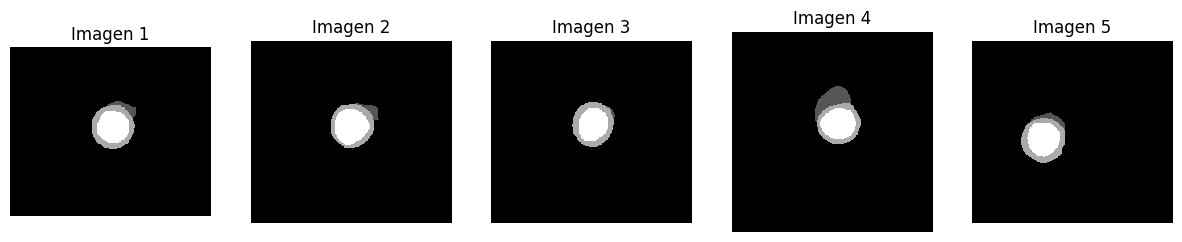

In [12]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [13]:
all_files = training_files + testing_files
images = [nib.load(file).get_fdata() for file in all_files]
image_shapes = [img.shape for img in images]
print(image_shapes)
average_shape = np.mean(image_shapes, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")
min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)

print(len(all_files))
print(f"Tamaño mínimo: {min_shape}")
print(f"Tamaño máximo: {max_shape}")

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

In [14]:
# LINE ADDITION
def add_line_to_image(image, line_position=None, line_thickness=2):
    image_with_line = image.copy()
    
    if line_position is None:
        mask_indices = np.where(image > 0)
        if len(mask_indices[0]) == 0: 
            return image_with_line
        line_position = (mask_indices[0].min() + mask_indices[0].max()) // 2

    start = max(0, line_position - line_thickness // 2)
    end = min(image.shape[0], line_position + line_thickness // 2)
    mask_region = image[start:end, :] > 0
    image_with_line[start:end, :][mask_region] = 1
    return image_with_line

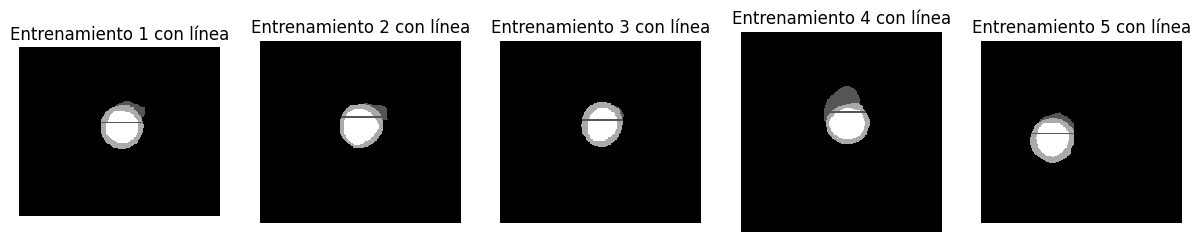

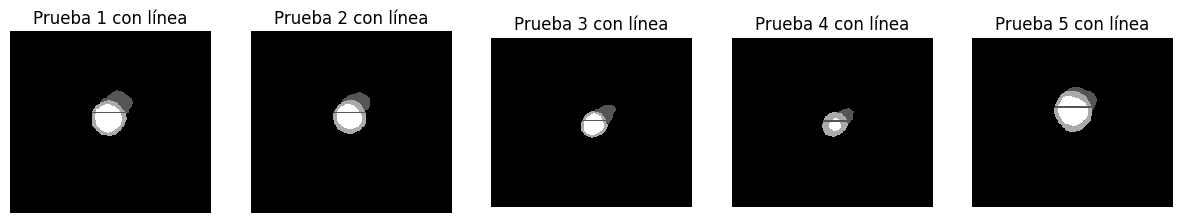

In [15]:
training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

training_images =  [nib.load(file) for file in training_files]
testing_images = [nib.load(file) for file in testing_files]

training_images_data = [file.get_fdata() for file in training_images]
testing_images_data = [file.get_fdata() for file in testing_images]

training_images_with_line = [add_line_to_image(img) for img in training_images_data]
testing_images_with_line = [add_line_to_image(img) for img in testing_images_data]

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, img in enumerate(training_images_with_line[:5]):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none')
    axs[i].axis("off")
    axs[i].set_title(f"Entrenamiento {i+1} con línea")
    #print(img.shape)
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, img in enumerate(testing_images_with_line[:5]):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none')
    axs[i].axis("off")
    axs[i].set_title(f"Prueba {i+1} con línea")
    #print(img.shape)
plt.show()

In [18]:
training_output_dir = '/mnt/nfs/home/liglesias/prueba_affine'
testing_output_dir = '/mnt/nfs/home/liglesias/prueba_affine'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        print(img.affine)
        print(img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, training_images_with_line, training_output_dir, training_files)
save_images(testing_images, training_images_with_line, testing_output_dir, testing_files)

[[-1. -0.  0.  0.]
 [-0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 216 256  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [ 1.      1.5625  1.5625 10.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset

KeyboardInterrupt: 

In [16]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_noise'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images_with_line(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images_with_line(training_images, training_images_with_line, training_output_dir, training_files)
save_images_with_line(testing_images, training_images_with_line, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise

In [99]:
training_files = list_nifti_files(training_dir)
print(training_dir)

training_path = training_files[0]
print(training_path)

image = nib.load(training_path)
print(type(image))

image_data = image.get_fdata()  # Los datos como array de NumPy
affine = image.affine  # La matriz affine

nifti_img = nib.Nifti1Image(image_data, affine, image.header)
nib.save(nifti_img, "/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/test.nii.gz")


/mnt/nfs/home/liglesias/data_acdc/masks_training
/mnt/nfs/home/liglesias/data_acdc/masks_training/patient001_frame12_gt.nii.gz
<class 'nibabel.nifti1.Nifti1Image'>


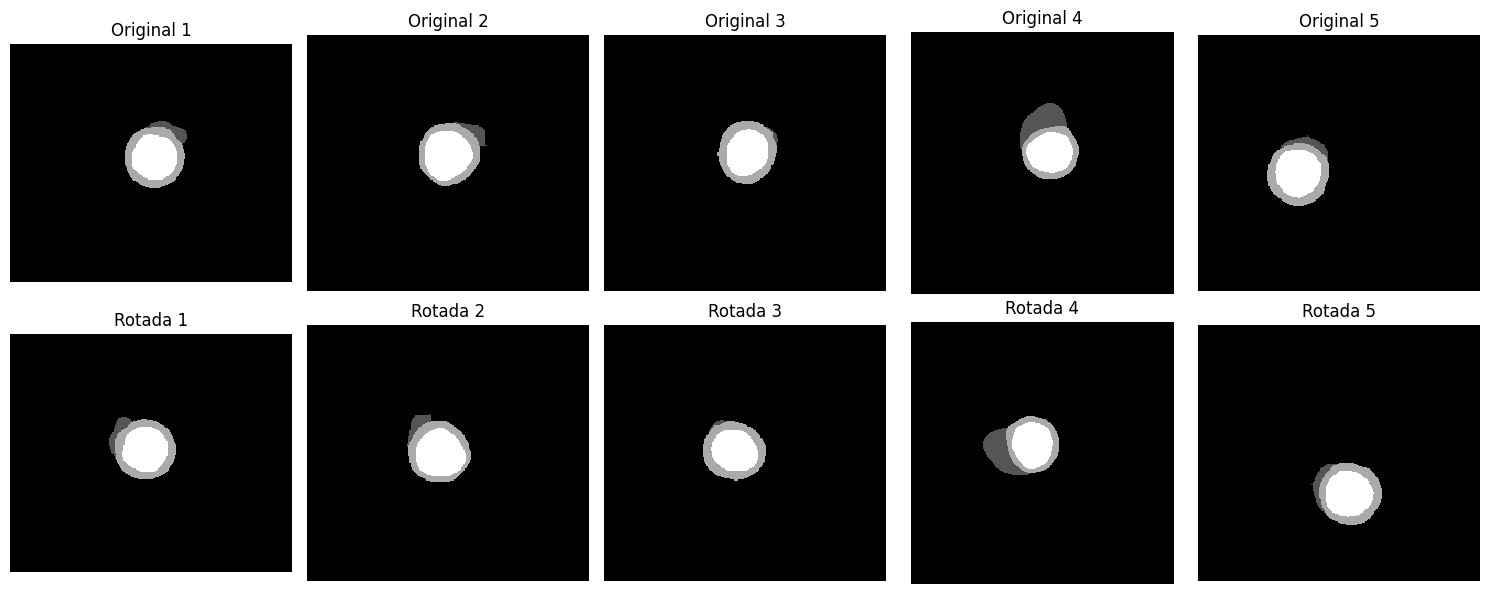

In [78]:
# ROTATION
from scipy.ndimage import rotate

def rotate_nifti_image(img_data, angle, axes=(0, 1)):
    rotated_img = np.zeros_like(img_data, dtype=np.float32)
    for i in range(img_data.shape[2]):
        rotated_img[:, :, i] = rotate(img_data[:, :, i], angle, axes=axes, reshape=False, order=1, mode='constant', cval=0)
    return rotated_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

angle = 90 

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

training_images =  [nib.load(file) for file in training_files]
testing_images = [nib.load(file) for file in testing_files]

training_images_data = [file.get_fdata() for file in training_images]
testing_images_data = [file.get_fdata() for file in testing_images]

rotated_training_images = [rotate_nifti_image(nib.load(file).get_fdata(), angle=angle) for file in training_files]
rotated_testing_images = [rotate_nifti_image(nib.load(file).get_fdata(), angle=angle) for file in testing_files]

# Solo imprimo 5 de training
n_images_to_show = 5
fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation='none')
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(rotated_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none')
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Rotada {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_noise'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, rotated_training_images, training_output_dir, training_files)
save_images(testing_images, rotated_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise

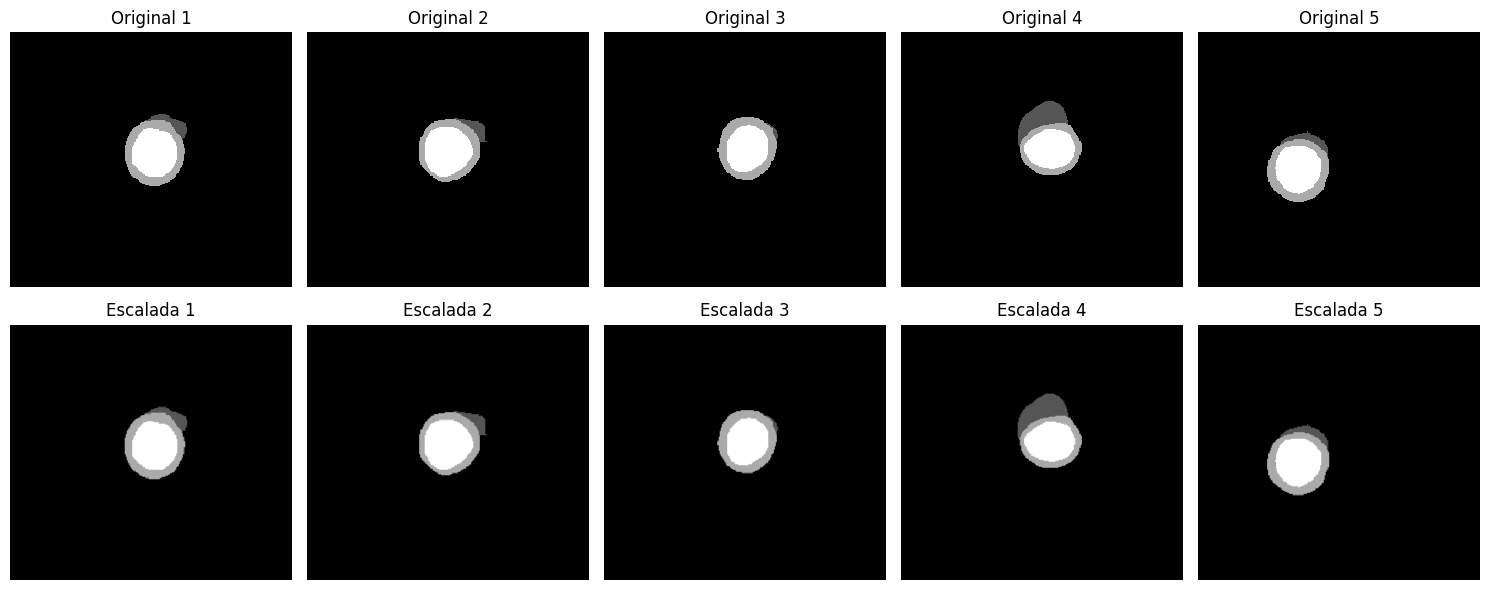

In [28]:
# RESIZE (NO FUNCIONA BIEN)
from scipy.ndimage import zoom

def resize_nifti_image(img_data, scale_factors):
    resized_img = zoom(img_data, scale_factors, order=1, mode='constant', cval=0)
    return resized_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

scale_factors = (2.0, 2.0, 1.0)  # Aumenta al doble en X e Y, mantiene Z igual

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

training_images =  [nib.load(file) for file in training_files]
testing_images = [nib.load(file) for file in testing_files]

training_images_data = [file.get_fdata() for file in training_images]
testing_images_data = [file.get_fdata() for file in testing_images]

resized_training_images = [resize_nifti_image(nib.load(file).get_fdata(), scale_factors=scale_factors) for file in training_files]
resized_testing_images = [resize_nifti_image(nib.load(file).get_fdata(), scale_factors=scale_factors) for file in testing_files]

# Solo imprimo 5 de training
n_images_to_show = 5
fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation='none', aspect='auto')
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(resized_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none', aspect='auto')
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Escalada {i+1}")

plt.tight_layout()
plt.show()

In [29]:
for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    resized_img = resize_nifti_image(img_data, scale_factors)
    print(f"Imagen {i+1} - Forma original: {img_data.shape}, Forma escalada: {resized_img.shape}")


Imagen 1 - Forma original: (216, 256, 10), Forma escalada: (432, 512, 10)
Imagen 2 - Forma original: (232, 256, 10), Forma escalada: (464, 512, 10)
Imagen 3 - Forma original: (232, 256, 10), Forma escalada: (464, 512, 10)
Imagen 4 - Forma original: (256, 256, 10), Forma escalada: (512, 512, 10)
Imagen 5 - Forma original: (232, 256, 10), Forma escalada: (464, 512, 10)


In [30]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_noise'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, resized_training_images, training_output_dir, training_files)
save_images(testing_images, resized_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise

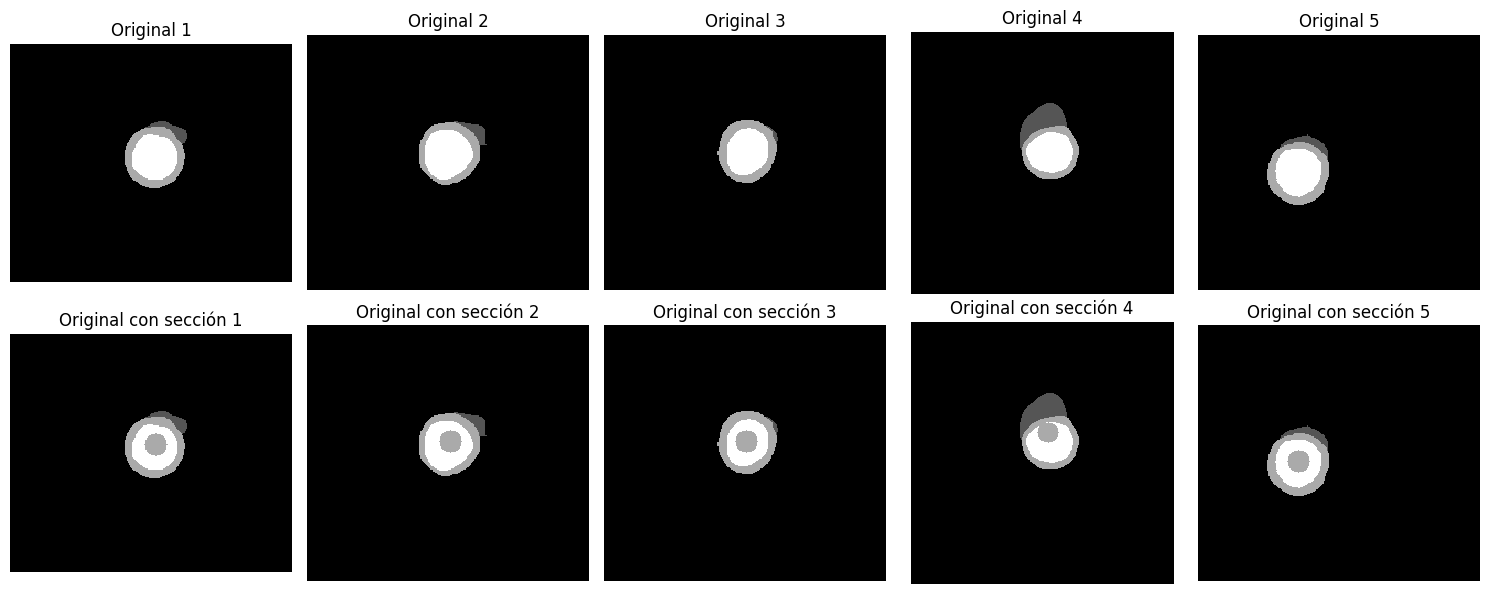

In [83]:
# SECTION ADDITION
import cv2
import nibabel as nib

def add_section_to_nifti_image(img_data, shape='circle', size=10):
    modified_img = img_data.copy()
    height, width, depth = img_data.shape

    for i in range(depth):
        mask = img_data[:, :, i].copy()
        
        coords = np.argwhere(mask > 0)
        if coords.size > 0:
            center_y, center_x = np.mean(coords, axis=0).astype(int)
            if shape == 'circle':
                cv2.circle(mask, (center_x, center_y), size, 2, -1)
            else:
                raise ValueError("Forma no soportada.")
            modified_img[:, :, i] = mask
    return modified_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

training_images = [nib.load(file) for file in training_files]
testing_images = [nib.load(file) for file in testing_files]

training_images_data = [file.get_fdata() for file in training_images]
testing_images_data = [file.get_fdata() for file in testing_images]

section_training_images = [add_section_to_nifti_image(nib.load(file).get_fdata()) for file in training_files]
section_testing_images = [add_section_to_nifti_image(nib.load(file).get_fdata()) for file in testing_files]

n_images_to_show = 5
fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation='none')
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(section_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none')
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Original con sección {i+1}")

plt.tight_layout()
plt.show()

In [84]:
training_output_dir = '/mnt/nfs/home/liglesias/masks_training_circle'
testing_output_dir = '/mnt/nfs/home/liglesias/masks_testing_circle'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, section_training_images, training_output_dir, training_files)
save_images(testing_images, section_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient007_frame07_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/masks_raining_cicle/patient008_frame0

In [46]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_noise'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, section_training_images, training_output_dir, training_files)
save_images(testing_images, section_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_noise

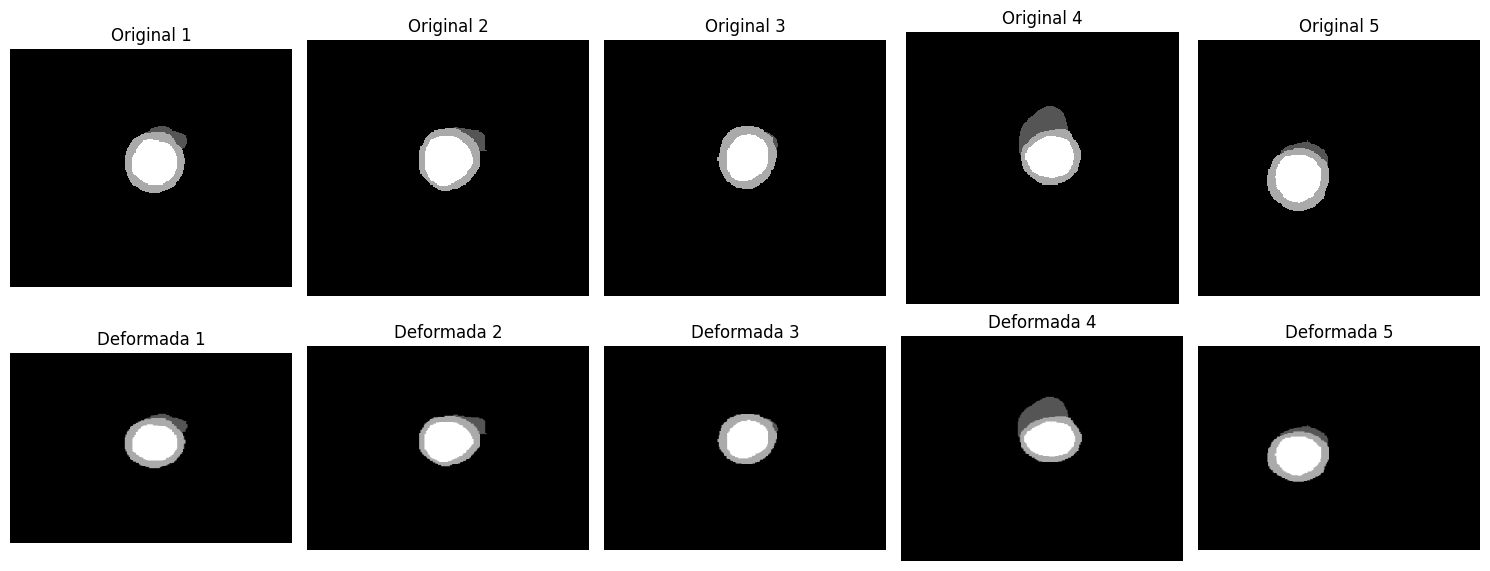

In [56]:
# DEFORMATION
from scipy.ndimage import zoom

def deform_nifti_image(img_data, scale_x=1.0, scale_y=1.0):
    deformed_slices = []
    zoom_factors = (scale_y, scale_x) 

    for i in range(img_data.shape[2]): 
        deformed_slice = zoom(
            img_data[:, :, i],
            zoom_factors,
            order=1,
            mode="constant",
            cval=0 
        )
        deformed_slices.append(deformed_slice)

    deformed_img = np.stack(deformed_slices, axis=2)
    return deformed_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

scale_x = 1.5  
scale_y = 1.2 

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

deformed_training_images = [
    deform_nifti_image(nib.load(file).get_fdata(), scale_x=scale_x, scale_y=scale_y)
    for file in training_files
]
deformed_testing_images = [
    deform_nifti_image(nib.load(file).get_fdata(), scale_x=scale_x, scale_y=scale_y)
    for file in testing_files
]

n_images_to_show = 5
fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(deformed_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

In [20]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/training_deformation'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/testing_deformation'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, deformed_training_images, training_output_dir, training_files)
save_images(testing_images, deformed_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/training_deformation

In [15]:
# SPHERE ADDITION

import raster_geometry as rg
rg.circle(shape=(20,20), radius=5, position=(0.7,0.2)).astype(int)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1,

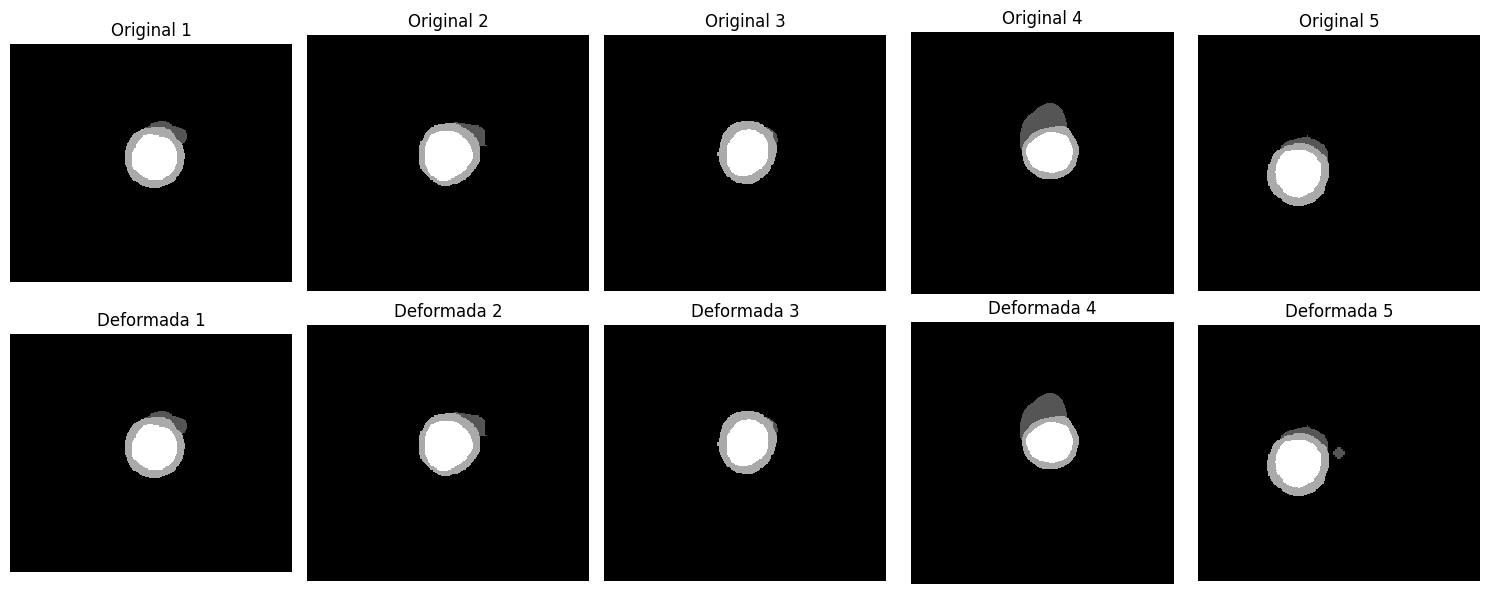

In [ ]:
# SPHERE ADDITION
from scipy.ndimage import zoom

import raster_geometry as rg
def add_sphere_to_nifti_image(img_data, sphere_radius=5, sphere_position=(0.7, 0.2)):
    modified_slices = []
    shape = img_data.shape[:2] 
    
    sphere = rg.circle(shape=shape, radius=sphere_radius, position=sphere_position).astype(int)
    
    for i in range(img_data.shape[2]):
        modified_slice = np.maximum(img_data[:, :, i], sphere)
        modified_slices.append(modified_slice)

    modified_img = np.stack(modified_slices, axis=2)
    return modified_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

sphere_radius = 5
sphere_position = (0.5, 0.5)
n_images_to_show = 5

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

modified_training_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, sphere_position=sphere_position)
    for file in training_files
]
modified_testing_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, sphere_position=sphere_position)
    for file in testing_files
]

n_images_to_show = 5
fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(modified_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

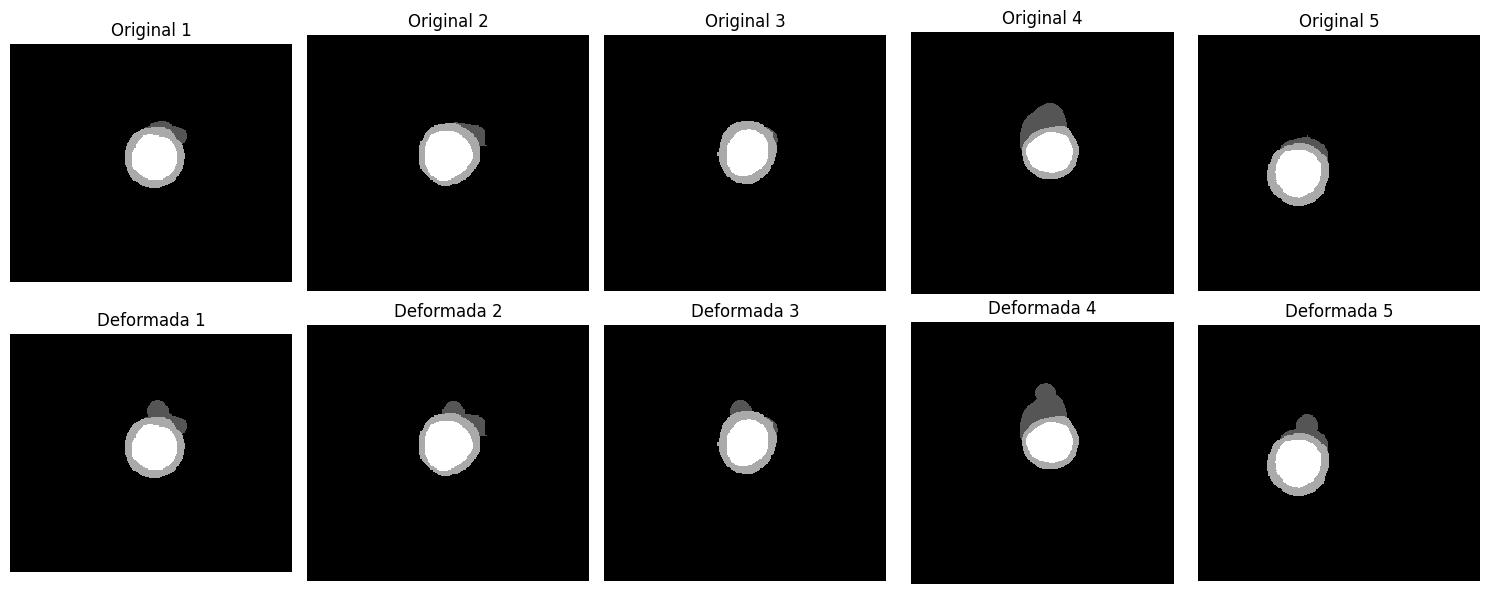

In [22]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import raster_geometry as rg
import cv2

def add_sphere_to_nifti_image(img_data, sphere_radius=5, background_value=0):
    shape = img_data.shape
    central_slice_index = shape[2] // 2
    central_slice = img_data[:, :, central_slice_index]
    
    # Find the edge of the mask by scanning from the left
    mask = central_slice.copy()
    coords = np.argwhere(mask > background_value)
    if coords.size == 0:
        raise ValueError("No mask found in the central slice")
    
    # Assuming we want to place the sphere at the first occurrence of the mask
    edge_position = coords[0]
    
    # Convert edge position to relative position
    position = (edge_position[0] / shape[0], edge_position[1] / shape[1], 0.5)
    
    sphere = rg.sphere(shape=shape, radius=sphere_radius, position=position).astype(int)
    
    modified_slices = []
    for i in range(img_data.shape[2]):
        modified_slice = np.maximum(img_data[:, :, i], sphere[:, :, i])
        modified_slices.append(modified_slice)

    modified_img = np.stack(modified_slices, axis=2)
    return modified_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

sphere_radius = 10
n_images_to_show = 5
background_value = 0

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

modified_training_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value)
    for file in training_files
]
modified_testing_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value)
    for file in testing_files
]

fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(modified_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

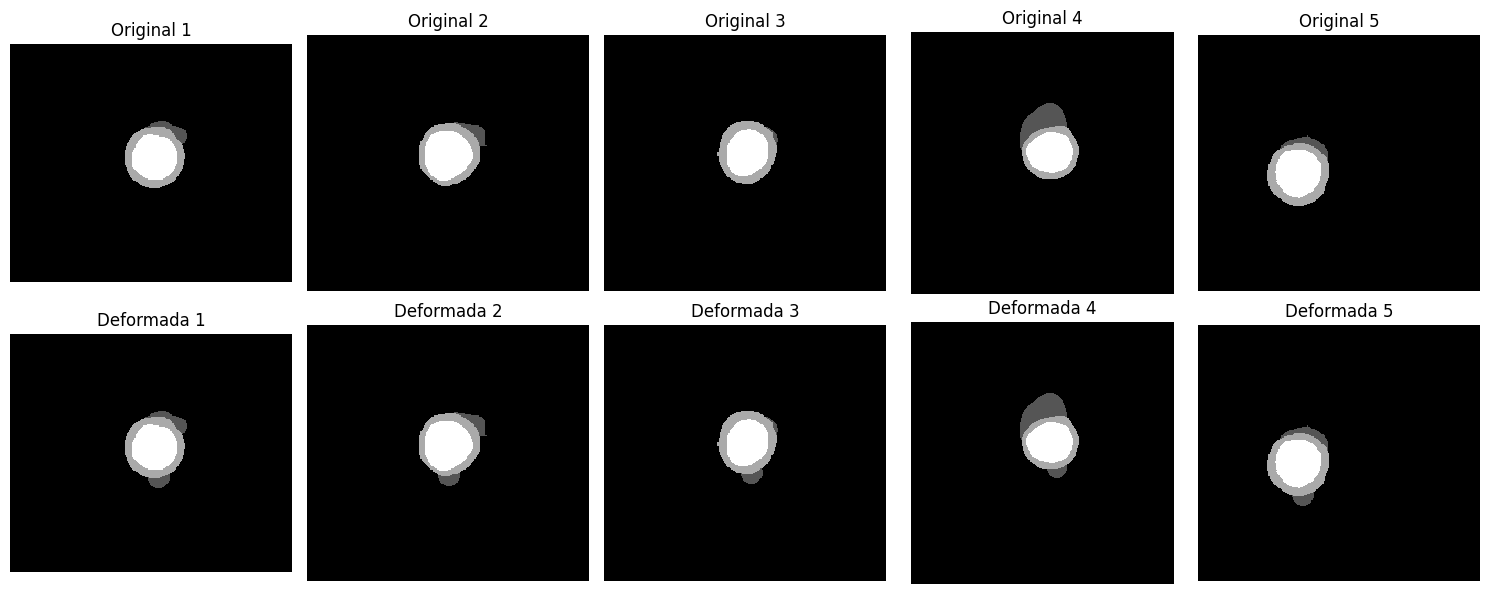

In [23]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import raster_geometry as rg
import cv2

def add_sphere_to_nifti_image(img_data, sphere_radius=5, background_value=0):
    shape = img_data.shape
    central_slice_index = shape[2] // 2
    central_slice = img_data[:, :, central_slice_index]
    
    # Find the edge of the mask by scanning from the left
    mask = central_slice.copy()
    coords = np.argwhere(mask > background_value)
    if coords.size == 0:
        raise ValueError("No mask found in the central slice")
    
    # Assuming we want to place the sphere at the last occurrence of the mask
    edge_position = coords[-1]
    
    # Convert edge position to relative position
    position = (edge_position[0] / shape[0], edge_position[1] / shape[1], 0.5)
    
    sphere = rg.sphere(shape=shape, radius=sphere_radius, position=position).astype(int)
    
    modified_slices = []
    for i in range(img_data.shape[2]):
        modified_slice = np.maximum(img_data[:, :, i], sphere[:, :, i])
        modified_slices.append(modified_slice)

    modified_img = np.stack(modified_slices, axis=2)
    return modified_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

sphere_radius = 10
n_images_to_show = 5
background_value = 0

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

modified_training_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value)
    for file in training_files
]
modified_testing_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value)
    for file in testing_files
]

fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(modified_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
# SPHERE ADDITION IN EVERY SLICE
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import raster_geometry as rg
import cv2

def add_sphere_to_nifti_image(img_data, sphere_radius=5, background_value=0):
    shape = img_data.shape
    modified_slices = []
    
    for i in range(img_data.shape[2]):
        slice_data = img_data[:, :, i]
        
        # Find the edge of the mask by scanning from the left
        mask = slice_data.copy()
        coords = np.argwhere(mask > background_value)
        if coords.size == 0:
            modified_slices.append(slice_data)
            continue
        
        # Assuming we want to place the sphere at the last occurrence of the mask
        edge_position = coords[-1]
        
        # Convert edge position to relative position
        position = (edge_position[0] / shape[0], edge_position[1] / shape[1], i / shape[2])
        
        sphere = rg.sphere(shape=shape, radius=sphere_radius, position=position).astype(int)
        
        modified_slice = np.maximum(slice_data, sphere[:, :, i])
        modified_slices.append(modified_slice)

    modified_img = np.stack(modified_slices, axis=2)
    return modified_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

sphere_radius = 10
n_images_to_show = 5
background_value = 0

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

modified_training_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value)
    for file in training_files
]
modified_testing_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value)
    for file in testing_files
]

fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(modified_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

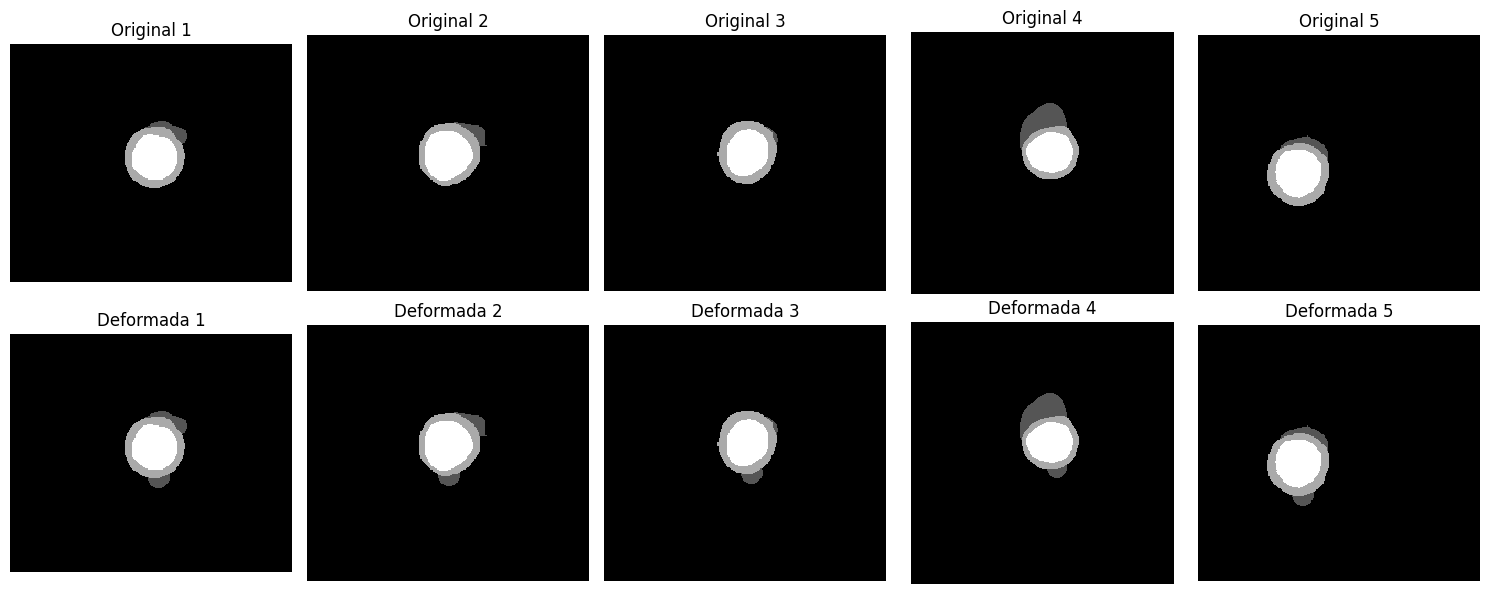

In [ ]:
# SPHERE ADDITION IN CENTRAL SLICES
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import raster_geometry as rg
import cv2

def add_sphere_to_nifti_image(img_data, sphere_radius=5, background_value=0, central_slices_range=2):
    shape = img_data.shape
    central_slice_index = shape[2] // 2
    modified_slices = []
    
    for i in range(img_data.shape[2]):
        slice_data = img_data[:, :, i]
        
        if central_slice_index - central_slices_range <= i <= central_slice_index + central_slices_range:
            # Find the edge of the mask by scanning from the left
            mask = slice_data.copy()
            coords = np.argwhere(mask > background_value)
            if coords.size == 0:
                modified_slices.append(slice_data)
                continue
            
            # Assuming we want to place the sphere at the last occurrence of the mask
            edge_position = coords[-1]
            
            # Convert edge position to relative position
            position = (edge_position[0] / shape[0], edge_position[1] / shape[1], i / shape[2])
            
            sphere = rg.sphere(shape=shape, radius=sphere_radius, position=position).astype(int)
            
            modified_slice = np.maximum(slice_data, sphere[:, :, i])
        else:
            modified_slice = slice_data
        
        modified_slices.append(modified_slice)

    modified_img = np.stack(modified_slices, axis=2)
    return modified_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

sphere_radius = 10
n_images_to_show = 5
background_value = 0
central_slices_range = 2  # This will cover 4 slices (2 before and 2 after the central slice)

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

modified_training_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value, central_slices_range=central_slices_range)
    for file in training_files
]
modified_testing_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value, central_slices_range=central_slices_range)
    for file in testing_files
]

fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(modified_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

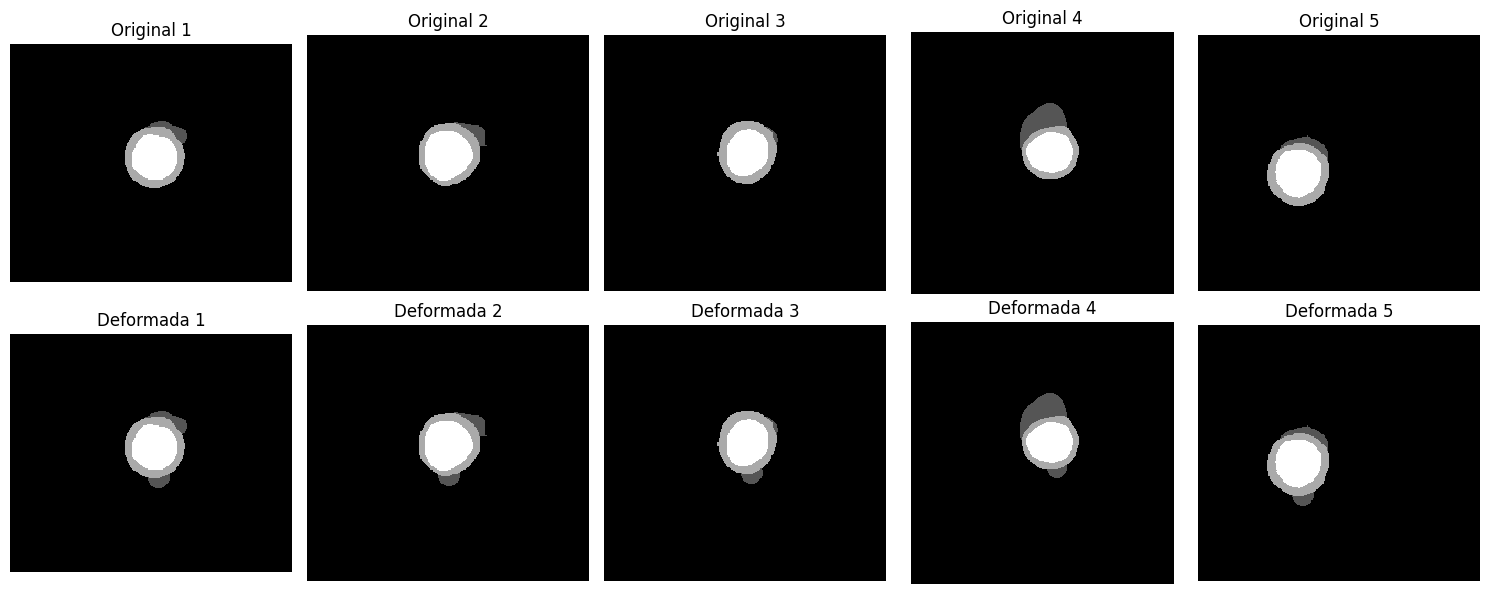

In [ ]:
# SPHERE ADDITION IN CENTRAL SLICES (CONTINUOUS SPHERE DIFFERENT POSITION IN EACH SLICE)
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import raster_geometry as rg
import cv2

def add_sphere_to_nifti_image(img_data, sphere_radius=10, background_value=0, central_slices_range=2):
    shape = img_data.shape
    central_slice_index = shape[2] // 2
    modified_slices = []
    
    for i in range(img_data.shape[2]):
        slice_data = img_data[:, :, i]
        
        if central_slice_index - central_slices_range <= i <= central_slice_index + central_slices_range:
            # Find the edge of the mask by scanning from the left
            mask = slice_data.copy()
            coords = np.argwhere(mask > background_value)
            if coords.size == 0:
                modified_slices.append(slice_data)
                continue
            
            # Assuming we want to place the sphere at the last occurrence of the mask
            edge_position = coords[-1]
            
            # Convert edge position to relative position
            position = (edge_position[0] / shape[0], edge_position[1] / shape[1], 0.5)
            
            # Adjust the sphere radius based on the distance from the central slice
            distance_from_central = abs(central_slice_index - i)
            adjusted_radius = sphere_radius * (1 - (distance_from_central / (central_slices_range + 1)))
            
            sphere = rg.sphere(shape=shape, radius=adjusted_radius, position=position).astype(int)
            
            modified_slice = np.maximum(slice_data, sphere[:, :, i])
        else:
            modified_slice = slice_data
        
        modified_slices.append(modified_slice)

    modified_img = np.stack(modified_slices, axis=2)
    return modified_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

sphere_radius = 10
n_images_to_show = 5
background_value = 0
central_slices_range = 2  # This will cover 5 slices (2 before, central, and 2 after)

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

modified_training_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value, central_slices_range=central_slices_range)
    for file in training_files
]
modified_testing_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value, central_slices_range=central_slices_range)
    for file in testing_files
]

fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(modified_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

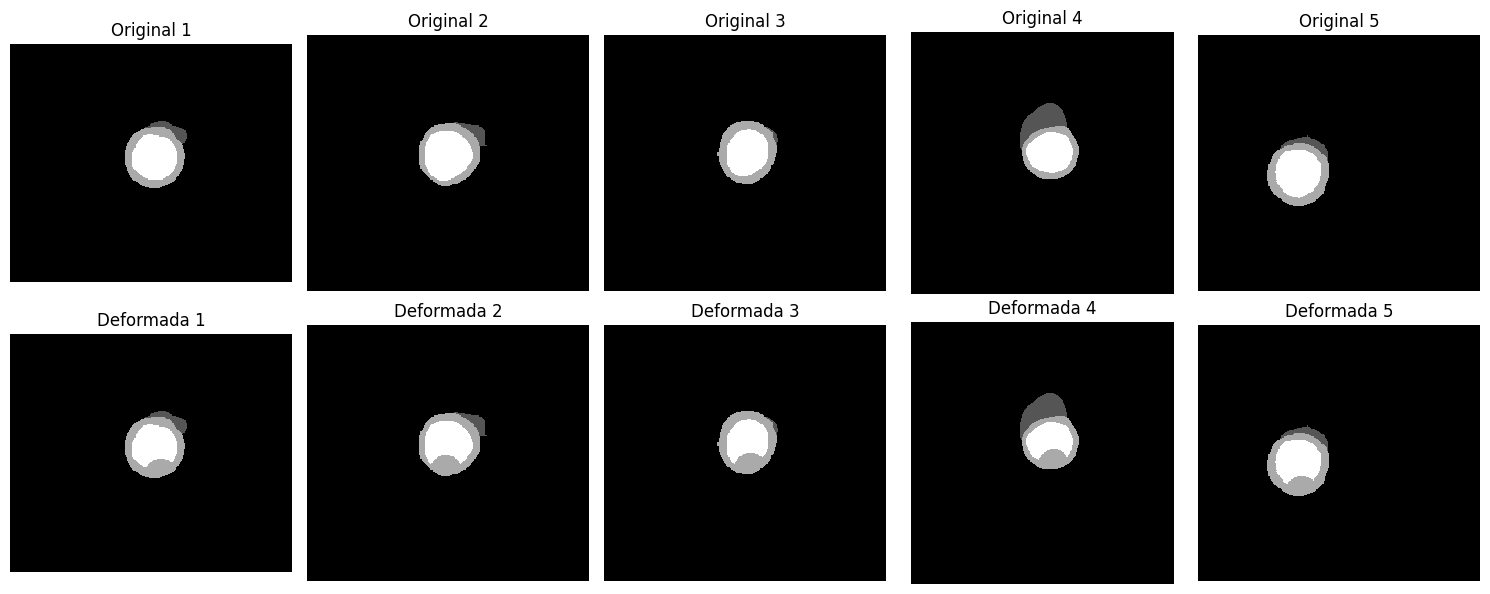

In [19]:
# SPHERE ADDITION IN CENTRAL SLICES (CONTINUOUS SPHERE SAME POSITION IN EACH SLICE (no junto a la máscara))
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import raster_geometry as rg
import cv2

def add_sphere_to_nifti_image(img_data, sphere_radius=10, background_value=0, central_slices_range=2):
    shape = img_data.shape
    central_slice_index = shape[2] // 2
    modified_slices = []
    
    # Find the edge of the mask by scanning from the left
    slice_data = img_data[:, :, central_slice_index + 1]
    mask = slice_data.copy()
    coords = np.argwhere(mask > background_value)
    if coords.size == 0:
        modified_slices.append(slice_data)
    
    # Assuming we want to place the sphere at the last occurrence of the mask
    edge_position = coords[-1]
    
    # Convert edge position to relative position
    position = (edge_position[0] / shape[0], edge_position[1] / shape[1], 0.5)
    
    for i in range(img_data.shape[2]):
        slice_data = img_data[:, :, i]
        
        if central_slice_index - central_slices_range <= i <= central_slice_index + central_slices_range:
            # Adjust the sphere radius based on the distance from the central slice
            distance_from_central = abs(central_slice_index - i)
            adjusted_radius = sphere_radius * (1 - (distance_from_central / (central_slices_range + 1)))
            
            sphere = rg.sphere(shape=shape, radius=adjusted_radius, position=position).astype(int) * 2
            
            modified_slice = np.where((sphere[:, :, i] == 2) & (slice_data > background_value), 2, slice_data)
        else:
            modified_slice = slice_data
        
        modified_slices.append(modified_slice)

    modified_img = np.stack(modified_slices, axis=2)
    return modified_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

sphere_radius = 15
n_images_to_show = 5
background_value = 0
central_slices_range = 2  # This will cover 5 slices (2 before, central, and 2 after)

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

modified_training_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value, central_slices_range=central_slices_range)
    for file in training_files
]
modified_testing_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value, central_slices_range=central_slices_range)
    for file in testing_files
]

fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(modified_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

In [20]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_sphere'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_sphere'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, modified_training_images, training_output_dir, training_files)
save_images(testing_images, modified_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_train

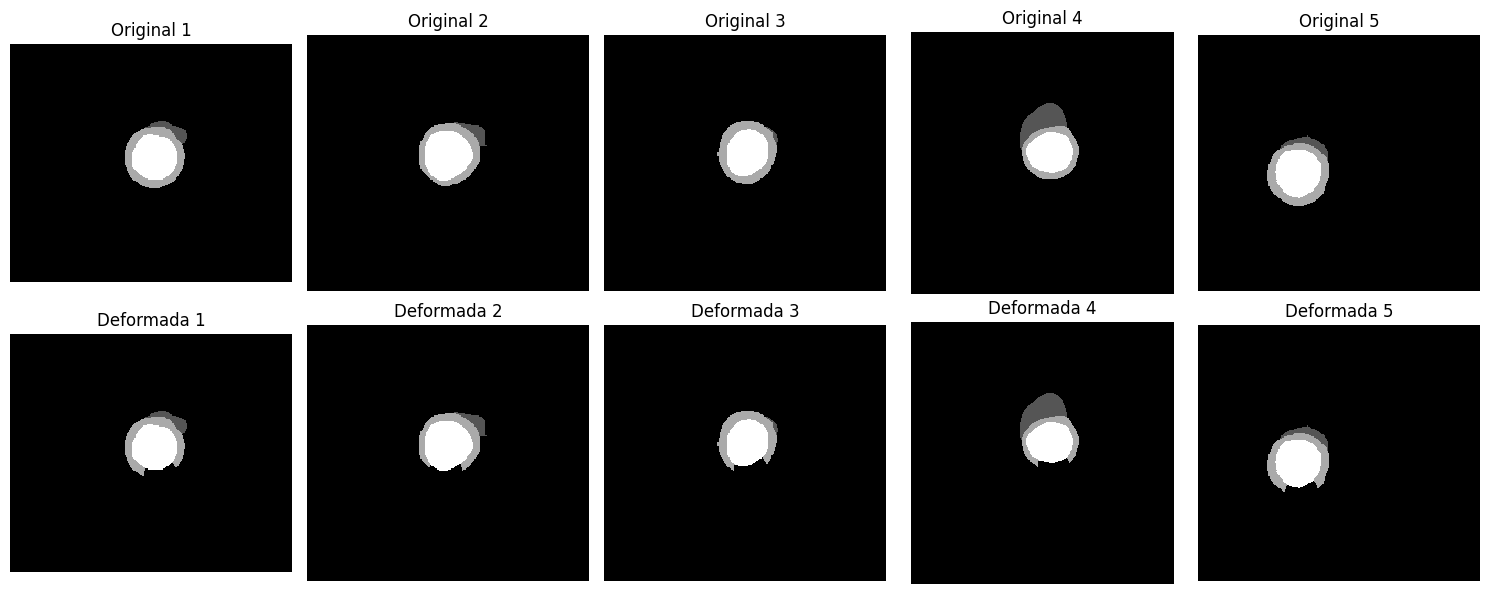

In [18]:
# SPHERE ADDITION IN CENTRAL SLICES (en la zona del ventriculo sigue siendo ventriculo y la zona del miocardio se convierte en background)
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import raster_geometry as rg
import cv2

def add_sphere_to_nifti_image(img_data, sphere_radius=10, background_value=0, central_slices_range=2):
    shape = img_data.shape
    central_slice_index = shape[2] // 2
    modified_slices = []
    
    # Find the edge of the mask by scanning from the left
    slice_data = img_data[:, :, central_slice_index + 1]
    mask = slice_data.copy()
    coords = np.argwhere(mask > background_value)
    if coords.size == 0:
        modified_slices.append(slice_data)
    
    # Assuming we want to place the sphere at the last occurrence of the mask
    edge_position = coords[-1]
    
    # Convert edge position to relative position
    position = (edge_position[0] / shape[0], edge_position[1] / shape[1], 0.5)
    
    for i in range(img_data.shape[2]):
        slice_data = img_data[:, :, i]
        
        if central_slice_index - central_slices_range <= i <= central_slice_index + central_slices_range:
            # Adjust the sphere radius based on the distance from the central slice
            distance_from_central = abs(central_slice_index - i)
            adjusted_radius = sphere_radius * (1 - (distance_from_central / (central_slices_range + 1)))
            
            sphere = rg.sphere(shape=shape, radius=adjusted_radius, position=position).astype(int) * 2
            
            # Update labels: label 2 to 0, keep label 3 as is
            modified_slice = np.where((sphere[:, :, i] == 2) & (slice_data == 2), 0, slice_data)
            modified_slice = np.where((sphere[:, :, i] == 2) & (slice_data == 3), 3, modified_slice)
        else:
            modified_slice = slice_data
        
        modified_slices.append(modified_slice)

    modified_img = np.stack(modified_slices, axis=2)
    return modified_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

sphere_radius = 15
n_images_to_show = 5
background_value = 0
central_slices_range = 2  # This will cover 5 slices (2 before, central, and 2 after)

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

modified_training_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value, central_slices_range=central_slices_range)
    for file in training_files
]
modified_testing_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value, central_slices_range=central_slices_range)
    for file in testing_files
]

fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(modified_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

In [19]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_sphere'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_sphere'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, modified_training_images, training_output_dir, training_files)
save_images(testing_images, modified_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_train

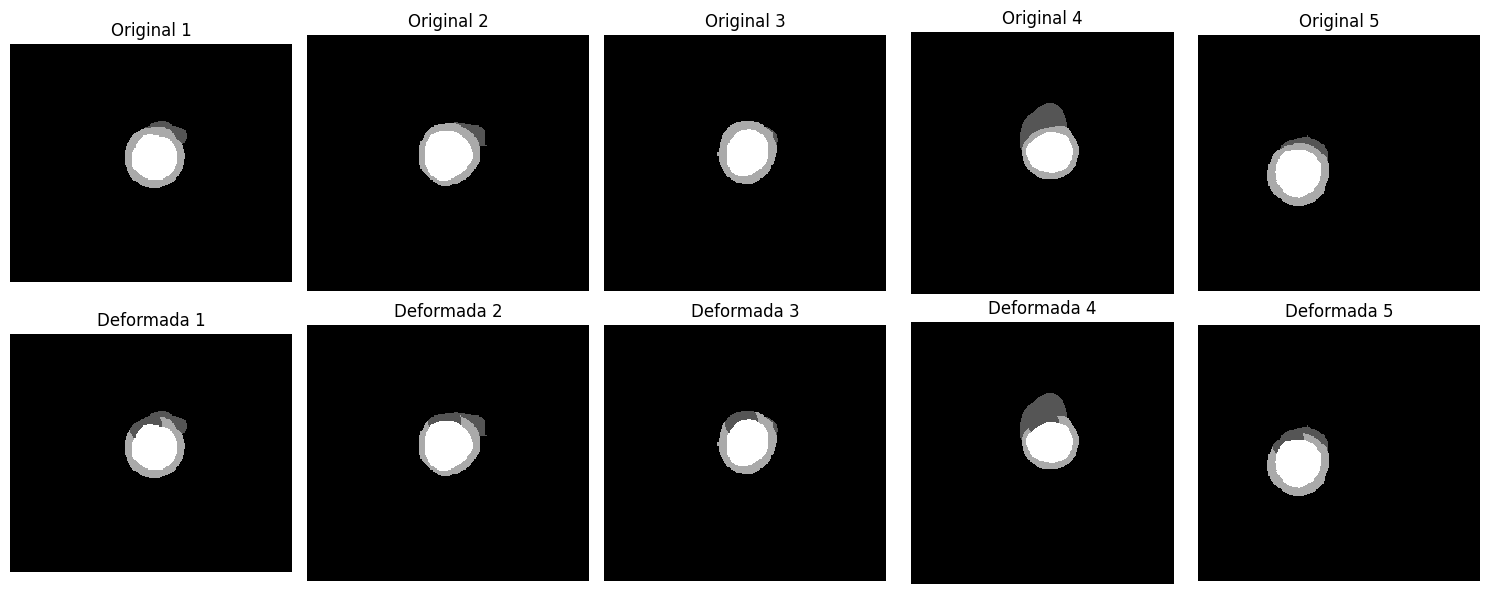

In [53]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import raster_geometry as rg
import cv2

def add_sphere_to_nifti_image(img_data, sphere_radius=10, background_value=0, central_slices_range=2):
    shape = img_data.shape
    central_slice_index = shape[2] // 2
    modified_slices = []
    
    # Find the first occurrence of label 3 by scanning from the left
    slice_data = img_data[:, :, central_slice_index + 1]
    mask = slice_data.copy()
    coords = np.argwhere(mask == 3)
    if coords.size == 0:
        modified_slices.append(slice_data)
    
    # Assuming we want to place the sphere at the first occurrence of label 3
    edge_position = coords[0]
    
    # Convert edge position to relative position
    position = (edge_position[0] / shape[0], edge_position[1] / shape[1], 0.5)
    
    for i in range(img_data.shape[2]):
        slice_data = img_data[:, :, i]
        
        if central_slice_index - central_slices_range <= i <= central_slice_index + central_slices_range:
            # Adjust the sphere radius based on the distance from the central slice
            distance_from_central = abs(central_slice_index - i)
            adjusted_radius = sphere_radius * (1 - (distance_from_central / (central_slices_range + 1)))
            
            sphere = rg.sphere(shape=shape, radius=adjusted_radius, position=position).astype(int) * 2
            
            # Update labels: label 2 to 1, keep label 3 as is, and ensure label 0 remains 0
            modified_slice = np.where((sphere[:, :, i] == 2) & (slice_data == 2), 1, slice_data)
            modified_slice = np.where((sphere[:, :, i] == 2) & (slice_data == 3), 3, modified_slice)
            modified_slice = np.where((sphere[:, :, i] == 2) & (slice_data == 0), 0, modified_slice)
            modified_slice = np.where((sphere[:, :, i] == 2) & (slice_data != 2) & (slice_data != 3) & (slice_data != 0), 1, modified_slice)
        else:
            modified_slice = slice_data
        
        modified_slices.append(modified_slice)

    modified_img = np.stack(modified_slices, axis=2)
    return modified_img

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

sphere_radius = 15
n_images_to_show = 5
background_value = 0
central_slices_range = 2  # This will cover 5 slices (2 before, central, and 2 after)

modified_training_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value, central_slices_range=central_slices_range)
    for file in training_files
]
modified_testing_images = [
    add_sphere_to_nifti_image(nib.load(file).get_fdata(), sphere_radius=sphere_radius, background_value=background_value, central_slices_range=central_slices_range)
    for file in testing_files
]

fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(modified_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

In [54]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_sphere_3'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_sphere_3'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, modified_training_images, training_output_dir, training_files)
save_images(testing_images, modified_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere_3/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere_3/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere_3/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere_3/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere_3/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere_3/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere_3/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere_3/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_sphere_3/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/dat

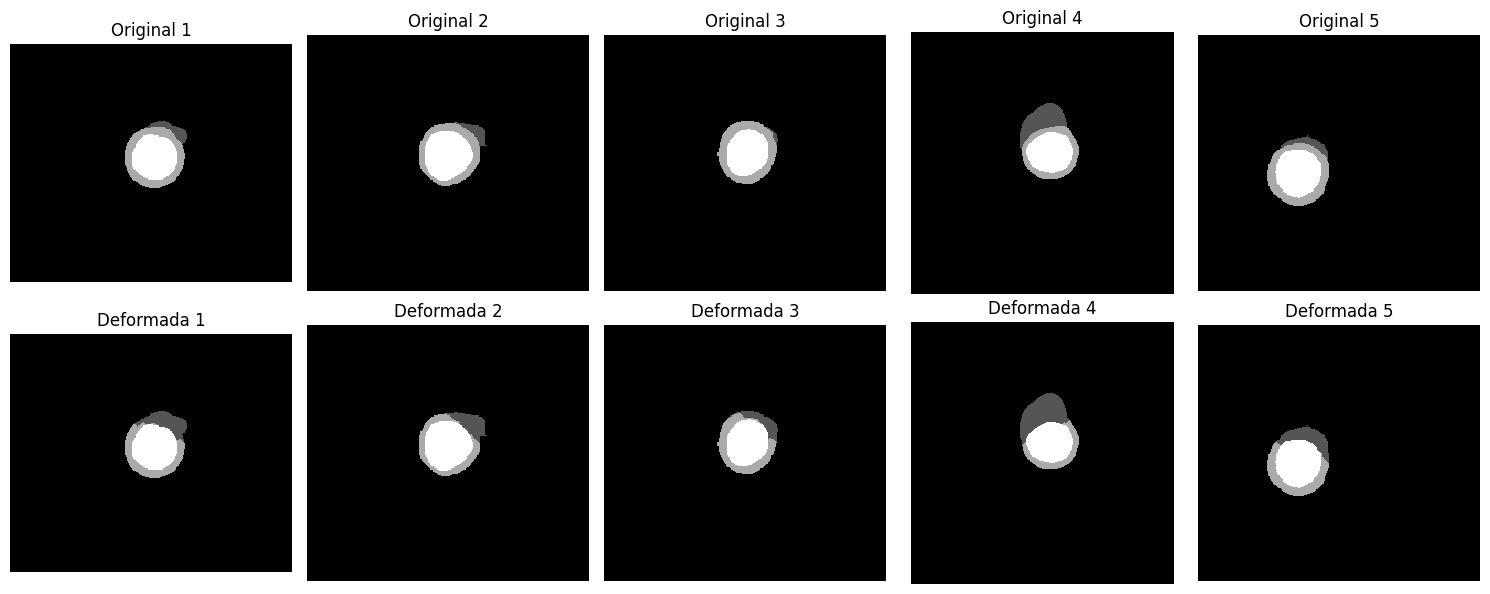

In [16]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from scipy.ndimage import binary_dilation

def process_labels(img_data, dilation_iterations=3):
    mask_label_1 = (img_data == 1)
    dilated_mask_label_1 = binary_dilation(mask_label_1, iterations=dilation_iterations)
    
    mask_label_2 = (img_data == 2)
    intersection_mask = dilated_mask_label_1 & mask_label_2
    
    img_data[intersection_mask] = 1
    
    return img_data

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

dilation_iterations = 6
n_images_to_show = 5

# Assuming training_files and testing_files are defined
modified_training_images = [
    process_labels(nib.load(file).get_fdata(), dilation_iterations=dilation_iterations)
    for file in training_files
]
modified_testing_images = [
    process_labels(nib.load(file).get_fdata(), dilation_iterations=dilation_iterations)
    for file in testing_files
]

fig, axs = plt.subplots(2, n_images_to_show, figsize=(15, 6))

for i, file in enumerate(training_files[:n_images_to_show]):
    img_data = nib.load(file).get_fdata()
    axs[0, i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray", interpolation="none")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i+1}")

for i, img in enumerate(modified_training_images[:n_images_to_show]):
    axs[1, i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation="none")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Deformada {i+1}")

plt.tight_layout()
plt.show()

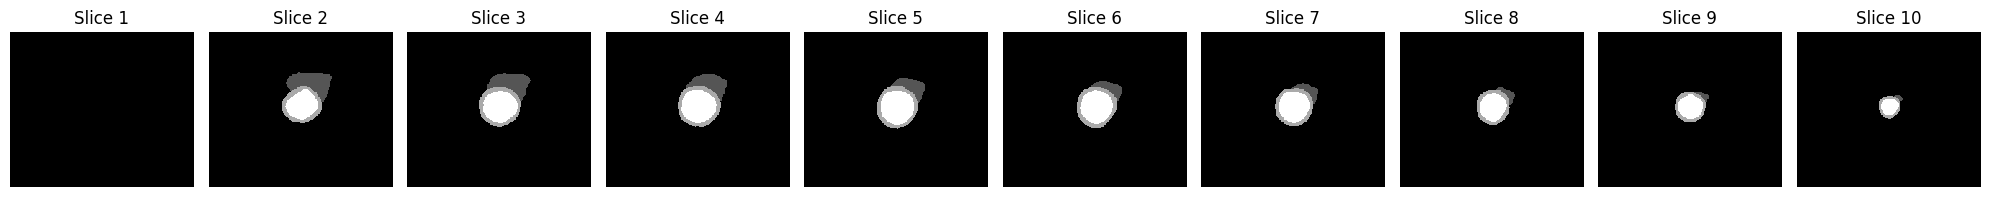

In [22]:
# Mostrar todos los slices de la imagen 'patient001_frame01_gt.nii'
image_filename = 'patient001_frame01_gt.nii'
image_file_path = None

# Buscar el archivo en los directorios de entrenamiento
for file in training_files:
    if image_filename in file:
        image_file_path = file
        break

if image_file_path:
    first_image = nib.load(image_file_path).get_fdata()
    n_slices = first_image.shape[2]

    fig, axs = plt.subplots(1, n_slices, figsize=(20, 5))
    for i in range(n_slices):
        axs[i].imshow(first_image[:, :, i], cmap="gray", interpolation="none")
        axs[i].axis("off")
        axs[i].set_title(f"Slice {i+1}")

    plt.tight_layout()
    plt.show()
else:
    print(f'El archivo {image_filename} no se encontró en los archivos de entrenamiento.')

In [52]:
training_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_training_dilation'
testing_output_dir = '/mnt/nfs/home/liglesias/data_acdc/masks_testing_dilation'

os.makedirs(training_output_dir, exist_ok=True)
os.makedirs(testing_output_dir, exist_ok=True)

def save_images(images, new_data, output_dir, file_names):
    for img, new_data, file_name in zip(images, new_data, file_names):
        nifti_img = nib.Nifti1Image(new_data, img.affine, img.header)
        output_path = os.path.join(output_dir, os.path.basename(file_name))
        nib.save(nifti_img, output_path)
        print(f"Imagen guardada en {output_path}")

save_images(training_images, modified_training_images, training_output_dir, training_files)
save_images(testing_images, modified_testing_images, testing_output_dir, testing_files)

Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_dilation/patient001_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_dilation/patient002_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_dilation/patient002_frame12_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_dilation/patient003_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_dilation/patient004_frame15_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_dilation/patient005_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_dilation/patient005_frame13_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_dilation/patient006_frame16_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/data_acdc/masks_training_dilation/patient007_frame01_gt.nii.gz
Imagen guardada en /mnt/nfs/home/liglesias/dat